<a href="https://colab.research.google.com/github/choi-jeongwon/NLP_project_25Fall/blob/main/code_arxiv_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import spacy
import re
import os
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from tqdm import tqdm

nltk.download('vader_lexicon')

!pip install gensim
import gensim

nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 45.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
data_folder = "/content/drive/MyDrive/Colab_Notebooks/"
arxiv_file_path = os.path.join(data_folder, "arXiv-DataFrame.csv")
df = pd.read_csv(arxiv_file_path)
df = df[['Title', 'Summary', 'Primary Category']].copy()
df.head()

Mounted at /content/drive


,Title,Summary,Primary Category
0,Dynamic Backtracking,Because of their occasional need to return to ...,cs.AI
1,A Market-Oriented Programming Environment and ...,Market price systems constitute a well-underst...,cs.AI
2,An Empirical Analysis of Search in GSAT,We describe an extensive study of search in GS...,cs.AI
3,The Difficulties of Learning Logic Programs wi...,As real logic programmers normally use cut (!)...,cs.AI
4,Software Agents: Completing Patterns and Const...,To support the goal of allowing users to recor...,cs.AI


In [4]:
# Cleaning discipline variable
def clean_category_specific(category):
    """
    Cleans the category string.
    - If it starts with 'q-', keeps the part up to the first period (e.g., 'q-bio.NC').
    - Otherwise, keeps only the initial alphabetic prefix (e.g., 'cs.AI' -> 'cs').
    """
    if isinstance(category, str):
        if category.startswith('q-'):
            parts = re.split(r'[.-]', category, maxsplit=2)
            if len(parts) > 1:
                delimiter = category[len(parts[0])]
                return f"{parts[0]}{delimiter}{parts[1]}"
            else:
                return parts[0]
        else:
            match = re.match(r'^([a-zA-Z]+)', category)
            if match:
                return match.group(1)
    return category

df['Cleaned_Primary_Category'] = df['Primary Category'].apply(clean_category_specific)

print("\nSample of cleaned category values:")
print(df[['Primary Category', 'Cleaned_Primary_Category']].head(20))

print("\nValue counts for cleaned categories (top 20):")
print(df['Cleaned_Primary_Category'].value_counts().head(20))

# Keep only selected disciplines
categories_to_keep = ['cs', 'math', 'physics', 'q-bio', 'cond']

df_filtered = df[df['Cleaned_Primary_Category'].isin(categories_to_keep)].copy()

print("\nCounts by discipline after filtering:")
print(df_filtered['Cleaned_Primary_Category'].value_counts().sort_index())

disc_key = pd.DataFrame({
    "code":   ["cs",       "math",       "physics", "cond",             "q-bio"],
    "label":  ["Computer Science",
               "Mathematics",
               "Physics",
               "Condensed Matter",
               "Quantitative Biology"]
})

print("\nDiscipline code key:")
print(disc_key.to_string(index=False))

#sampling
n_per_discipline = 200
df_sample = (
    df_filtered
    .groupby('Cleaned_Primary_Category', group_keys=False)
    .apply(lambda x: x.sample(n=n_per_discipline, random_state=42))
    .reset_index(drop=True)
)

print("\nSampled counts per discipline:")
print(df_sample['Cleaned_Primary_Category'].value_counts().sort_index())

df_sample['paper_id'] = np.arange(1, len(df_sample) + 1)
df_sample = df_sample[['paper_id', 'Title', 'Summary', 'Cleaned_Primary_Category']]
print("\nHead of final analysis dataset:")
print(df_sample.head())




Sample of cleaned category values:
   Primary Category Cleaned_Primary_Category
0             cs.AI                       cs
1             cs.AI                       cs
2             cs.AI                       cs
3             cs.AI                       cs
4             cs.AI                       cs
5             cs.AI                       cs
6             cs.AI                       cs
7             cs.AI                       cs
8             cs.AI                       cs
9             cs.AI                       cs
10            cs.AI                       cs
11            cs.AI                       cs
12            cs.AI                       cs
13            cs.AI                       cs
14            cs.AI                       cs
15            cs.AI                       cs
16            cs.AI                       cs
17            cs.AI                       cs
18            cs.AI                       cs
19            cs.AI                       cs

Value counts for c

/tmp/ipython-input-847593016.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=n_per_discipline, random_state=42))


In [7]:
out_drive = "/content/drive/MyDrive/df_sample.csv"
df_sample.to_csv(out_drive, index=False, encoding="utf-8")

In [ ]:
#define helper functions
def safe_divide(numerator, denominator):
    return numerator / denominator if denominator != 0 else 0

def to_float(x):
    if x is None: return np.nan
    if isinstance(x, str) and x.strip().lower() in {"", "na", "nan"}: return np.nan
    try: return float(x)
    except: return np.nan

def mean_ignore_na(seq, fallback=0.0):
    arr = np.array(seq, dtype=float)
    return float(np.nanmean(arr)) if np.isfinite(np.nanmean(arr)) else fallback

def kde_curve(x, gridsize=512):
    x = np.asarray(x, dtype=float)
    x = x[np.isfinite(x)]
    if x.size < 2:
        return None, None
    kde = stats.gaussian_kde(x)
    lo, hi = np.percentile(x, [0.5, 99.5])
    if not np.isfinite(lo) or not np.isfinite(hi) or lo == hi:
        lo, hi = float(np.min(x) - 1e-9), float(np.max(x) + 1e-9)
    grid = np.linspace(lo, hi, gridsize)
    return grid, kde(grid)

def eta_squared(groups):
    all_vals = np.concatenate(groups)
    grand = np.nanmean(all_vals)
    ss_total = np.nansum((all_vals - grand) ** 2)
    ss_between = sum(g.size * (np.nanmean(g) - grand) ** 2 for g in groups if g.size > 0)
    return (ss_between / ss_total) if ss_total > 0 else np.nan

In [ ]:
## Word properties analysis

#load datasets (dictionary)
nrc_df = pd.read_csv(f"{data_folder}/MRC_database.csv")

elp_df = pd.read_csv(f"{data_folder}/elp_database.csv", index_col=0)
elp_df = elp_df[elp_df.index.notnull()]
elp_df.index = elp_df.index.astype(str)
elp_dict = {k.lower(): v for k, v in elp_df.T.to_dict('list').items()}

print(elp_dict["happy"])
print(len(elp_dict))

/tmp/ipython-input-2070385477.py:9: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  elp_dict = {k.lower(): v for k, v in elp_df.T.to_dict('list').items()}


[70881.0, 11.17, 6.0, 9.0, 9.0, 4.0, 5.3, 4.67, 5.38, 5.38, 5.3, 5.3, 1.8, 7.2, 1.75, 7.32, 1323.5, 536.27, -0.88, 82.14, 1.0, 555.93, -0.75, 97.35, 1.0, 2.56]
79670


In [ ]:
#concreteness, frequency, and POS analysis
def get_text_properties(text_series, elp_dict):
    docs = list(nlp.pipe(text_series.fillna("")))
    all_conc, all_freq, all_nw = [], [], []

    # Initialize POS containers
    target_pos = ["NOUN", "VERB", "ADJ", "ADV"]
    all_pos_props = {pos: [] for pos in target_pos}

    for doc in docs:
        tokens, hal_vals, conc_vals = [], [], []
        # Count target POS
        pos_counts = {pos: 0 for pos in target_pos}

        # Only consider alpha tokens for NW and stats
        alpha_count = 0

        for token in doc:
            if token.is_alpha:
                alpha_count += 1
                tokens.append(token.lower_)

                # Check POS
                if token.pos_ in target_pos:
                    pos_counts[token.pos_] += 1

                v = elp_dict.get(token.lower_)
                if v is not None:
                    hv = to_float(v[1] if len(v) > 1 else None)
                    cv = to_float(v[25] if len(v) > 25 else None)
                    hal_vals.append(hv)
                    conc_vals.append(cv)

        all_conc.append(mean_ignore_na(conc_vals, fallback=0.0))
        all_freq.append(mean_ignore_na(hal_vals, fallback=0.0))
        all_nw.append(alpha_count)

        # Calculate proportions
        for pos in target_pos:
            all_pos_props[pos].append(safe_divide(pos_counts[pos], alpha_count))

    return all_nw, all_conc, all_freq, all_pos_props

# Title
title_nw, title_conc, title_freq, title_pos = get_text_properties(df_sample["Title"], elp_dict)
df_sample["title_NW"] = title_nw
df_sample["title_concreteness"] = title_conc
df_sample["title_hal_freq"] = title_freq
for pos, vals in title_pos.items():
    df_sample[f"title_{pos}_prop"] = vals

# Summary
sum_nw, sum_conc, sum_freq, sum_pos = get_text_properties(df_sample["Summary"], elp_dict)
df_sample["summary_NW"] = sum_nw
df_sample["summary_concreteness"] = sum_conc
df_sample["summary_hal_freq"] = sum_freq
for pos, vals in sum_pos.items():
    df_sample[f"summary_{pos}_prop"] = vals

/tmp/ipython-input-2183713081.py:13: RuntimeWarning: Mean of empty slice
  return float(np.nanmean(arr)) if np.isfinite(np.nanmean(arr)) else fallback


,title_NW,title_concreteness,title_hal_freq,summary_NW,summary_concreteness,summary_hal_freq
Cleaned_Primary_Category,,,,,,
cond,10.210,2.656510,11.083193,112.025,2.382063,12.177593
cs,9.085,2.608324,11.082811,134.910,2.398413,12.322123
math,8.155,2.358735,11.209521,83.370,2.287461,12.445039
physics,10.285,2.667362,11.258012,129.625,2.399193,12.222979
q-bio,11.030,2.614756,11.101498,161.445,2.397064,12.057285


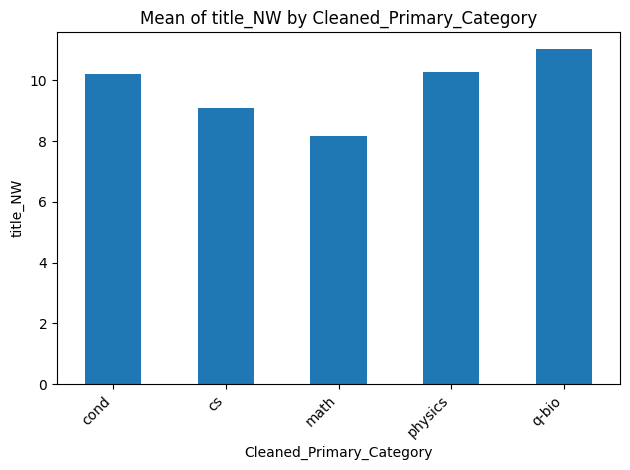

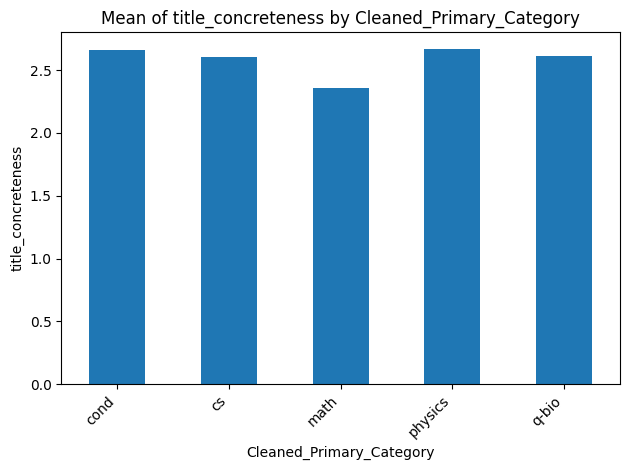

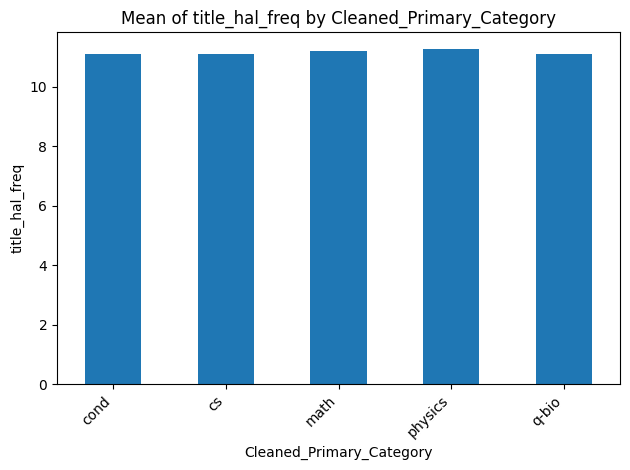

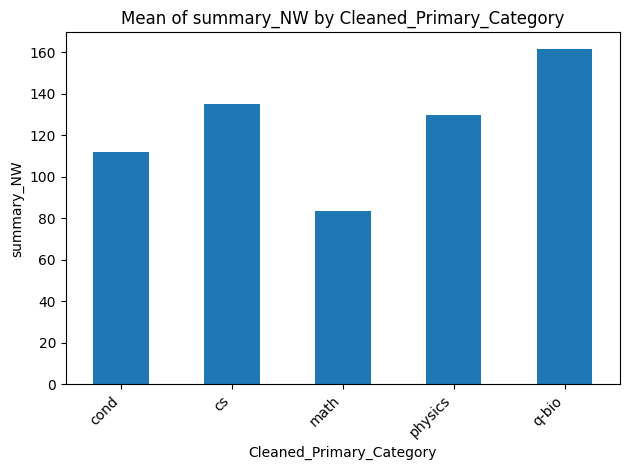

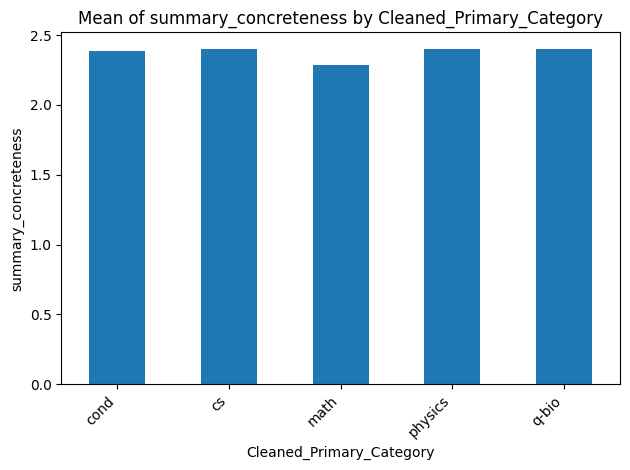

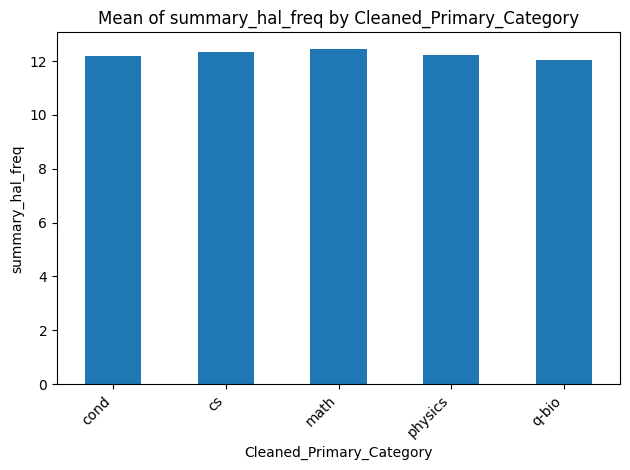

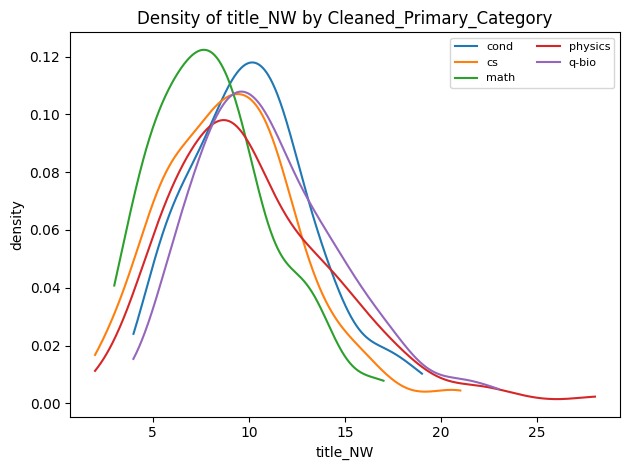

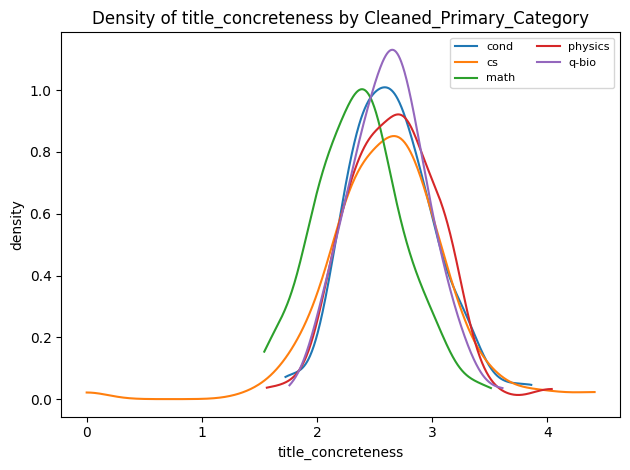

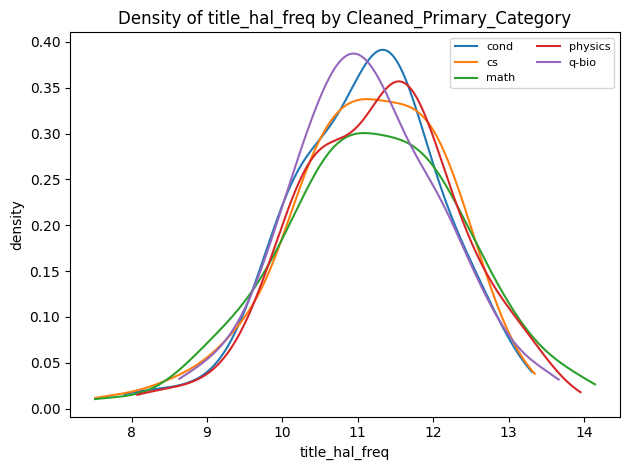

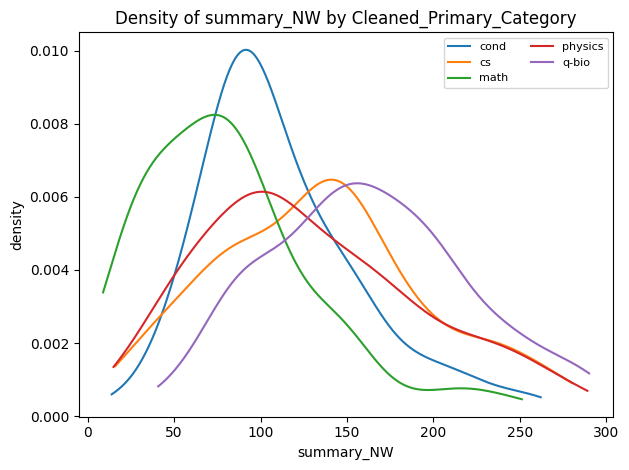

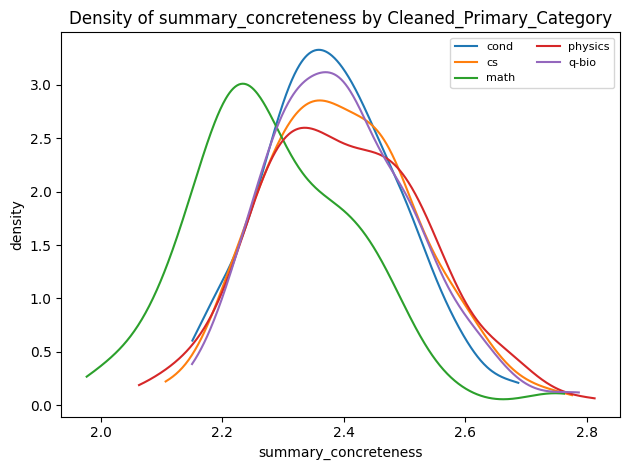

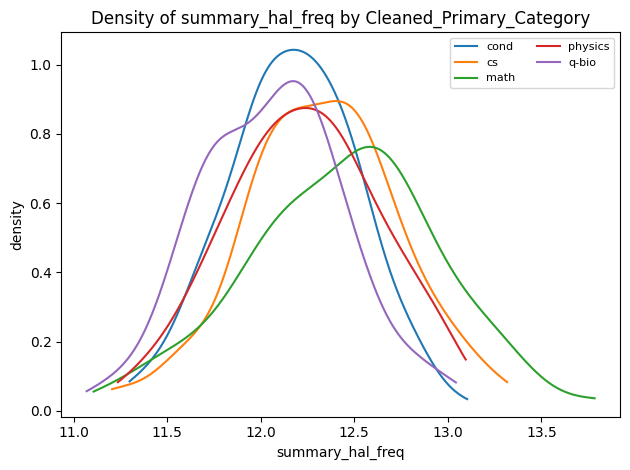

In [ ]:
#statistical analysis - anova
measures = [
    "title_NW","title_concreteness","title_hal_freq",
    "summary_NW","summary_concreteness","summary_hal_freq"
]
cat_col = "Cleaned_Primary_Category"

group_means = (
    df_sample.groupby(cat_col, dropna=False)[measures]
    .mean(numeric_only=True)
    .sort_index()
)
display(group_means)

for m in measures:
    plt.figure()
    group_means[m].plot(kind="bar")
    plt.title(f"Mean of {m} by {cat_col}")
    plt.ylabel(m)
    plt.xlabel(cat_col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

cats = sorted(df_sample[cat_col].dropna().unique().tolist())

for m in measures:
    plt.figure()
    for c in cats:
        x = df_sample.loc[df_sample[cat_col] == c, m].astype(float).dropna().values
        grid, y = kde_curve(x)
        if grid is None:
            continue
        plt.plot(grid, y, label=str(c))
    plt.title(f"Density of {m} by {cat_col}")
    plt.xlabel(m)
    plt.ylabel("density")
    plt.legend(ncol=2, fontsize=8)
    plt.tight_layout()
    plt.show()

test_rows = []
for m in measures:
    g = [df_sample.loc[df_sample[cat_col] == c, m].astype(float).dropna().values
         for c in cats]
    g = [arr for arr in g if arr.size > 1]
    if len(g) < 2:
        test_rows.append([m, np.nan, np.nan, np.nan, np.nan, np.nan])
        continue
    F, pA = stats.f_oneway(*g)
    H, pK = stats.kruskal(*g)
    eta2 = eta_squared(g)
    test_rows.append([m, F, pA, eta2, H, pK])

tests = pd.DataFrame(test_rows,
                  columns=["measure", "anova_F", "anova_p", "eta2", "kruskal_H", "kruskal_p"]
)

In [ ]:
from pathlib import Path
data_folder = "/content/drive/MyDrive/Colab_Notebooks/"
out_dir = Path(data_folder) / "plots_cleaned_primary"
out_dir.mkdir(parents=True, exist_ok=True)

cat_col = "Cleaned_Primary_Category"

# Define all measures to analyze individually
measures = [
    "title_NW","title_concreteness","title_hal_freq",
    "summary_NW","summary_concreteness","summary_hal_freq",
    "title_NOUN_prop","title_VERB_prop","title_ADJ_prop","title_ADV_prop",
    "summary_NOUN_prop","summary_VERB_prop","summary_ADJ_prop","summary_ADV_prop",
]


measures = [m for m in measures if m in df_sample.columns]

# Create and save summary table (means + counts)
mean_table = (
    df_sample.groupby(cat_col, dropna=False)[measures]
    .mean(numeric_only=True)
    .sort_index()
)
count_table = df_sample.groupby(cat_col).size().rename("n")
summary_table = mean_table.copy()
summary_table.insert(0, "n", count_table)

print("Summary Table (Means by Category):")
display(summary_table)
summary_table.to_csv(out_dir / "summary_means_by_cleaned_category.csv", index=True)

# Save bar plots (mean) for each measure
for m in measures:
    plt.figure()
    summary_table[m].plot(kind="bar")
    plt.title(f"Mean of {m} by {cat_col}")
    plt.ylabel(m)
    plt.xlabel(cat_col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(out_dir / f"mean_by_cleaned_{m}.png", dpi=300, bbox_inches="tight")
    plt.close()

# Save density plots for each measure
K = 8
top_cats = df_sample[cat_col].value_counts().head(K).index.tolist()
# Save density plots for each measure (for top-K categories)
K = 8
top_cats = df_sample[cat_col].value_counts().head(K).index.tolist()

for m in measures:
    plt.figure()
    for c in top_cats:
        s = df_sample.loc[df_sample[cat_col] == c, m].dropna()
        if s.empty:
            continue
        # Density curve
        sns.kdeplot(s, label=str(c), fill=False, common_norm=False)

    plt.title(f"Density of {m} by {cat_col} (Top {K} Categories)")
    plt.xlabel(m)
    plt.ylabel("Density")
    plt.legend(title=cat_col, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.savefig(out_dir / f"density_by_cleaned_{m}.png", dpi=300, bbox_inches="tight")
    plt.close()

Summary Table (Means by Category):


,n,title_NW,title_concreteness,title_hal_freq,summary_NW,summary_concreteness,summary_hal_freq,title_NOUN_prop,title_VERB_prop,title_ADJ_prop,title_ADV_prop,summary_NOUN_prop,summary_VERB_prop,summary_ADJ_prop,summary_ADV_prop
Cleaned_Primary_Category,,,,,,,,,,,,,,,
cond,200,10.210,2.656510,11.083193,112.025,2.382063,12.177593,0.297255,0.042527,0.114748,0.006235,0.305180,0.100588,0.126940,0.024577
cs,200,9.085,2.608324,11.082811,134.910,2.398413,12.322123,0.192212,0.055466,0.064258,0.004887,0.297093,0.122287,0.108820,0.028560
math,200,8.155,2.358735,11.209521,83.370,2.287461,12.445039,0.313801,0.025368,0.133238,0.010618,0.254285,0.095712,0.128996,0.031382
physics,200,10.285,2.667362,11.258012,129.625,2.399193,12.222979,0.275578,0.048656,0.107501,0.004502,0.299746,0.106523,0.118501,0.029194
q-bio,200,11.030,2.614756,11.101498,161.445,2.397064,12.057285,0.315517,0.051855,0.110792,0.001458,0.311948,0.109867,0.128814,0.029544


In [ ]:
def run_statistical_tests(df, category_col, metric_col, readable_name):
    """
    Runs ANOVA and Kruskal-Wallis tests for a given metric across categories.
    """
    print(f"\n{'='*40}")
    print(f"Statistical Tests for: {readable_name}")
    print(f"Column: {metric_col}")
    print(f"{'='*40}")

    if metric_col not in df.columns:
        print(f"[Error] Column '{metric_col}' not found. Skipping...")
        return

    data = df[[category_col, metric_col]].dropna()
    groups = [group[metric_col].values for name, group in data.groupby(category_col)]

    if len(groups) < 2:
        print("Not enough groups to perform statistical tests.")
        return

    # 1. ANOVA
    f_stat, p_val_anova = stats.f_oneway(*groups)
    print(f"ANOVA F-stat:       {f_stat:.2f}")
    print(f"ANOVA p-value:      {p_val_anova:.4e} {'(*Significant)' if p_val_anova < 0.05 else ''}")

    # 2. Kruskal-Wallis (Non-Parametric)
    h_stat, p_val_kw = stats.kruskal(*groups)
    print(f"Kruskal-Wallis H:   {h_stat:.2f}")
    print(f"Kruskal-Wallis p:   {p_val_kw:.4e} {'(*Significant)' if p_val_kw < 0.05 else ''}")

    # 3. Effect Size (Eta-Squared)
    grand_mean = data[metric_col].mean()
    ss_total = ((data[metric_col] - grand_mean)**2).sum()
    ss_between = sum(len(g) * (g.mean() - grand_mean)**2 for g in groups)

    if ss_total != 0:
        eta_squared = ss_between / ss_total
    else:
        eta_squared = 0

    effect_label = "Small"
    if eta_squared > 0.06: effect_label = "Medium"
    if eta_squared > 0.14: effect_label = "Large"

    print(f"Eta-Squared:        {eta_squared:.3f} ({effect_label} effect)")

category_column = "Cleaned_Primary_Category"

metrics_map = {
    'Title Word Count':       'title_NW',
    'Title Concreteness':     'title_concreteness',
    'Title Frequency':        'title_hal_freq',
    'Summary Word Count':     'summary_NW',
    'Summary Concreteness':   'summary_concreteness',
    'Summary Frequency':      'summary_hal_freq'
}

current_df = df_sample

for name, col in metrics_map.items():
    run_statistical_tests(current_df, category_column, col, name)


Statistical Tests for: Title Word Count
Column: title_NW
ANOVA F-stat:       18.59
ANOVA p-value:      9.6034e-15 (*Significant)
Kruskal-Wallis H:   71.13
Kruskal-Wallis p:   1.3128e-14 (*Significant)
Eta-Squared:        0.070 (Medium effect)

Statistical Tests for: Title Concreteness
Column: title_concreteness
ANOVA F-stat:       17.13
ANOVA p-value:      1.3444e-13 (*Significant)
Kruskal-Wallis H:   73.68
Kruskal-Wallis p:   3.7819e-15 (*Significant)
Eta-Squared:        0.064 (Medium effect)

Statistical Tests for: Title Frequency
Column: title_hal_freq
ANOVA F-stat:       1.00
ANOVA p-value:      4.0905e-01 
Kruskal-Wallis H:   3.64
Kruskal-Wallis p:   4.5626e-01 
Eta-Squared:        0.004 (Small effect)

Statistical Tests for: Summary Word Count
Column: summary_NW
ANOVA F-stat:       50.26
ANOVA p-value:      1.4699e-38 (*Significant)
Kruskal-Wallis H:   181.59
Kruskal-Wallis p:   3.3888e-38 (*Significant)
Eta-Squared:        0.168 (Large effect)

Statistical Tests for: Summary Co

In [ ]:
#POS analysis
# Define output directory for grouped POS plots
out_dir_grouped = Path(data_folder) / "plots_cleaned_primary_grouped"
out_dir_grouped.mkdir(parents=True, exist_ok=True)

TARGET_POS = {"NOUN", "VERB", "ADJ", "ADV"}
cat_col = "Cleaned_Primary_Category"

# Collect available POS proportion columns
title_pos_cols   = [f"title_{p}_prop"   for p in TARGET_POS if f"title_{p}_prop"   in df_sample.columns]
summary_pos_cols = [f"summary_{p}_prop" for p in TARGET_POS if f"summary_{p}_prop" in df_sample.columns]

# Helper: make grouped bar plot from a wide mean table
def plot_grouped_bars(mean_wide: pd.DataFrame, title: str, fname: Path):
    ax = mean_wide.plot(kind="bar")
    ax.set_title(title)
    ax.set_xlabel(cat_col)
    ax.set_ylabel("Proportion")
    ax.legend(title="POS", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.savefig(fname, dpi=300, bbox_inches="tight")
    plt.close()

# Title POS grouped means
if title_pos_cols:
    means_title = (
        df_sample.groupby(cat_col, dropna=False)[title_pos_cols]
        .mean(numeric_only=True)
        .sort_index()
    )
    means_title_ren = means_title.rename(columns={c: c.split("_")[1] for c in means_title.columns})

    print("\nTitle POS Grouped Means:")
    display(means_title_ren)
    means_title_ren.to_csv(out_dir_grouped / "means_title_pos_by_cleaned.csv", index=True)

    plot_grouped_bars(
        means_title_ren,
        title=f"Title POS proportions (mean) by {cat_col}",
        fname=out_dir_grouped / "grouped_title_pos.png"
    )

# Summary POS grouped means
if summary_pos_cols:
    means_summary = (
        df_sample.groupby(cat_col, dropna=False)[summary_pos_cols]
        .mean(numeric_only=True)
        .sort_index()
    )
    means_summary_ren = means_summary.rename(columns={c: c.split("_")[1] for c in means_summary.columns})

    print("\nSummary POS Grouped Means:")
    display(means_summary_ren)
    means_summary_ren.to_csv(out_dir_grouped / "means_summary_pos_by_cleaned.csv", index=True)

    plot_grouped_bars(
        means_summary_ren,
        title=f"Summary POS proportions (mean) by {cat_col}",
        fname=out_dir_grouped / "grouped_summary_pos.png"
    )



Title POS Grouped Means:


,ADV,VERB,ADJ,NOUN
Cleaned_Primary_Category,,,,
cond,0.006235,0.042527,0.114748,0.297255
cs,0.004887,0.055466,0.064258,0.192212
math,0.010618,0.025368,0.133238,0.313801
physics,0.004502,0.048656,0.107501,0.275578
q-bio,0.001458,0.051855,0.110792,0.315517



Summary POS Grouped Means:


,ADV,VERB,ADJ,NOUN
Cleaned_Primary_Category,,,,
cond,0.024577,0.100588,0.126940,0.305180
cs,0.028560,0.122287,0.108820,0.297093
math,0.031382,0.095712,0.128996,0.254285
physics,0.029194,0.106523,0.118501,0.299746
q-bio,0.029544,0.109867,0.128814,0.311948


In [ ]:
## TF-IDF analysis
def get_words(docs):
    tokens = []
    for token in docs:
        if not token.is_punct and not token.is_space and not token.is_stop and token.is_alpha:
            tokens.append(token.lemma_.lower())
    return tokens

print("Tokenizing with spaCy...")
data_docs = list(nlp.pipe(df_sample['Summary'], batch_size=50))
processed_docs = [get_words(doc) for doc in data_docs]

dictionary = gensim.corpora.Dictionary(processed_docs)
dictionary.filter_extremes(no_below=5, no_above=0.5)

bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

vocab = pd.Series(dictionary.token2id).index
index = range(len(bow_corpus))

bow_df = pd.DataFrame(data=np.zeros((len(bow_corpus), len(dictionary)), dtype=np.float16),
                      index=index,
                      columns=vocab)

print("Building BoW DataFrame..")
for idx in tqdm(index):
    for id, freq in bow_corpus[idx]:
        bow_df.loc[idx, dictionary[id]] = freq

# Inverse Document Frequency (IDF)
num_documents = len(bow_df)

def idf(term):
    documents_containing_term = (bow_df[term] > 0).sum()
    return np.log(num_documents / (documents_containing_term + 1))
idf_series = pd.Series({term: idf(term) for term in tqdm(bow_df.columns)})

# Term Frequency (TF)
tf_df = bow_df.div(bow_df.sum(axis='columns'), axis='rows')

# TF-IDF Matrix
tfidf_df = tf_df.copy().multiply(idf_series, axis='columns')
tfidf_df

# Top Words by Category
tfidf_df['Category'] = df_sample['Cleaned_Primary_Category']
mean_tfidf_by_cat = tfidf_df.groupby('Category').mean()

print("\nTop 5 words per category based on mean TF-IDF:")
for cat in mean_tfidf_by_cat.index:
    print(f"\n--- {cat} ---")
    print(mean_tfidf_by_cat.loc[cat].sort_values(ascending=False).head(5))


Tokenizing with spaCy...
Building BoW DataFrame..


100%|██████████| 1972/1972 [00:00<00:00, 7036.01it/s]



Top 5 words per category based on mean TF-IDF:

--- cond ---
phase          0.027491
comment        0.024142
temperature    0.023320
transition     0.019261
magnetic       0.018205
Name: cond, dtype: float64

--- cs ---
algorithm    0.023714
system       0.019470
design       0.018427
problem      0.018236
paper        0.018043
Name: cs, dtype: float64

--- math ---
group      0.032563
space      0.030938
prove      0.026576
algebra    0.024893
theorem    0.021888
Name: math, dtype: float64

--- physics ---
death     0.024666
beam      0.017050
energy    0.016526
time      0.013896
field     0.012862
Name: physics, dtype: float64

--- q-bio ---
protein    0.035927
cell       0.024455
model      0.022337
dna        0.020700
gene       0.016083
Name: q-bio, dtype: float64


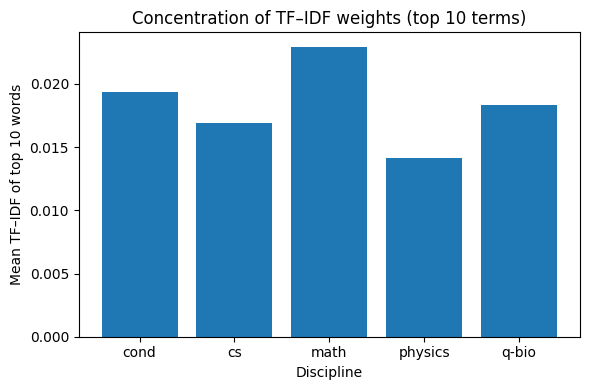

In [ ]:
tfidf_df['Category'] = df_sample['Cleaned_Primary_Category']
mean_tfidf_by_cat = tfidf_df.groupby('Category').mean()

top_k = 10

def mean_top_k(row, k=10):
    # sort TF–IDF values for this category and take top k
    top_vals = row.sort_values(ascending=False).head(k)
    return top_vals.mean()

mean_topk_tfidf = mean_tfidf_by_cat.apply(mean_top_k, axis=1, k=top_k)
mean_topk_tfidf_df = mean_topk_tfidf.reset_index()
mean_topk_tfidf_df.columns = ['Category', f'mean_tfidf_top_{top_k}']

mean_topk_tfidf_df

plt.figure(figsize=(6,4))
plt.bar(mean_topk_tfidf_df['Category'],
        mean_topk_tfidf_df[f'mean_tfidf_top_{top_k}'])
plt.xlabel('Discipline')
plt.ylabel(f'Mean TF–IDF of top {top_k} words')
plt.title(f'Concentration of TF–IDF weights (top {top_k} terms)')
plt.tight_layout()
plt.show()

In [ ]:
# Prepare data
X = tfidf_df.drop('Category', axis=1)
y = tfidf_df['Category']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train model
print("\nTraining Logistic Regression...")
classifier = LogisticRegression(max_iter=1000)
classifier.fit(X_train, y_train)

# Predict
predicted = classifier.predict(X_test)

# Evaluation
print(f"\nAccuracy: {metrics.accuracy_score(y_test, predicted):.4f}")
print("\nClassification Report:\n", metrics.classification_report(y_test, predicted))



Training Logistic Regression...

Accuracy: 0.7750

Classification Report:
               precision    recall  f1-score   support

        cond       0.76      0.95      0.84        40
          cs       0.69      0.90      0.78        40
        math       0.85      0.85      0.85        40
     physics       0.75      0.53      0.62        40
       q-bio       0.87      0.65      0.74        40

    accuracy                           0.78       200
   macro avg       0.78      0.78      0.77       200
weighted avg       0.78      0.78      0.77       200



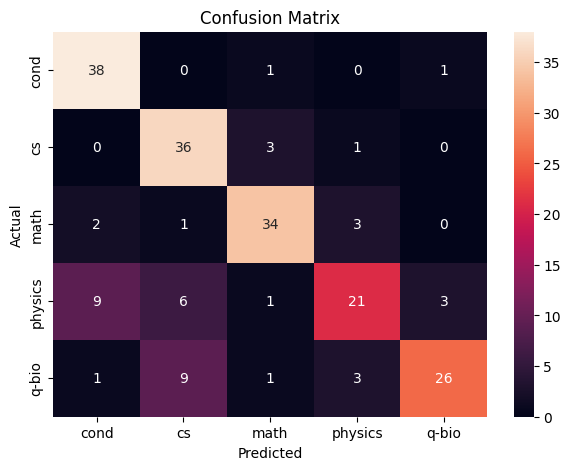

In [ ]:
# Confusion Matrix
plt.figure(figsize=(7, 5))
cm = metrics.confusion_matrix(y_test, predicted)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classifier.classes_, yticklabels=classifier.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')

In [ ]:
# Coefficients (Top words per class)
print("\nTop coefficients per class:")
vocab_list = X.columns.tolist()
# Handle multi-class coefficients (sklearn returns n_classes x n_features)
for i, class_label in enumerate(classifier.classes_):
    coefs = classifier.coef_[i]
    top_indices = np.argsort(coefs)[-10:][::-1]
    top_words = [vocab_list[j] for j in top_indices]
    print(f"{class_label}: {', '.join(top_words)}")


Top coefficients per class:
cond: temperature, phase, disorder, transition, magnetic, spin, atom, energy, trap, fermi
cs: algorithm, design, user, protocol, performance, problem, automata, graph, system, paper
math: space, group, algebra, prove, theorem, let, symplectic, integral, g, cohomology
physics: beam, pulse, plasma, energy, physical, average, electromagnetic, physics, electron, law
q-bio: protein, cell, dna, gene, model, tumor, growth, mechanism, population, immune
